# K-Vector Model

# imports

In [1]:
import sys
import cv2
import glob
import matplotlib.pyplot as plt

sys.path.append("../../../")
%matplotlib inline

%run ../../../ac/common/nps.py
%run ../../../ac/visualizer/plotter.py
%run ../../../al/optics/parameter.py
%run ../../../al/optics/projection.py
%run ../../../al/actor/face.py
%run ../../../al/actor/screen.py
%run ../../../al/feature/face/candide.py
%run ../../../ai/predictor/eyes/optical_axis.py
%run ../../../ds/everyone/npz/profile_generator.py

Using TensorFlow backend.


In [2]:
set_np_print_precision(4)
set_np_print_non_science()

# 0. 재료 준비

### 0.1 리소스 경로 

In [3]:
candide_path="/home/chy/archive-model/candide/candide.npz"
land_mark_path="/home/chy/archive-model/candide/shape_predictor_68_face_landmarks.dat"
model_path = "/home/chy/archive-model/incubator/ove/exp-home2-model.json"
weight_path = "/home/chy/archive-model/incubator/ove/exp-home2-24e-weights.hdf5"
face_img_dir = "/home/chy/dev-bench/auto-catch/notes/research/visual-optics/samples/face2/"

### 0.2 분석 데이터셋 로드

In [4]:
face_paths = glob.glob("{}/*.jpg".format(face_img_dir))

face_imgs = []
for path in face_paths:
    img = cv2.imread(path)
    face_imgs.append(img)

# 1. 양안 이미지

### 1.1 Create Components 

In [5]:
candide = Candide(candide_path, land_mark_path)
intrinsic_param = IntrinsicParameters(1221, 1222, 598, 804)
screen = Screen(1200, 1600)
camera = Camera(4.7, intrinsic_param, screen)
opt_predictor = OpticalAxisPredictor()
opt_predictor.load_model(model_path, weight_path)

### 1.2 Face::match()

In [6]:
face_actors = []
for img in face_imgs:
    face_model = FaceModel(candide)
    face = Face(camera, face_model, opt_predictor)
    face.match(img)
    face_actors.append(face)

### 1.3 Face::analysis()

In [7]:
for face in face_actors:
    face.analysis()

### 1.4 눈 영역 이미지

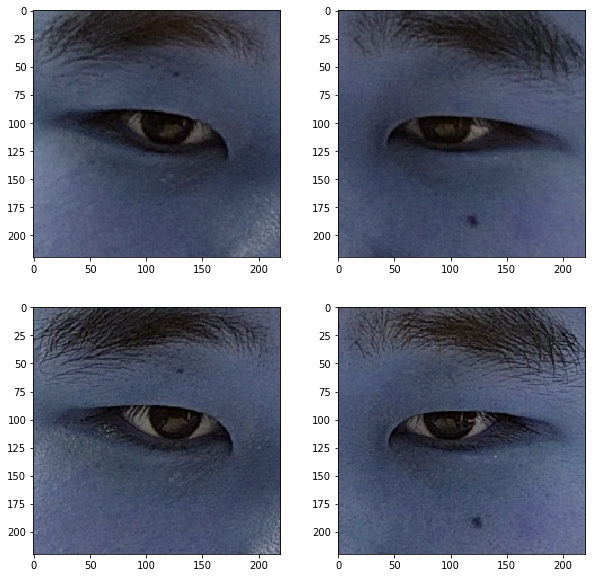

In [8]:
crop_eye_imgs = []
for face in face_actors:
    face.crop_eye_img()
    l_eye, r_eye = face.get_eye_imgs()
    crop_eye_imgs.append((l_eye, r_eye))

show_pair_images(crop_eye_imgs)

### 1.5 양안 깊이 거리 구하기 (from 카메라)

In [9]:
depth_measures = []
for face in face_actors:
    intercanthal, l_fissure, r_fissure = face.compute_depth()
    measures = (intercanthal, l_fissure, r_fissure)
    depth_measures.append(measures)
    print("intercanthal 추정 {}, l-fissure 추정 {}, r-fissure 추정 {}".format(*measures))

intercanthal 추정 276.398045596909, l-fissure 추정 278.7277142129046, r-fissure 추정 291.56759139238136
intercanthal 추정 285.3393164952957, l-fissure 추정 259.4026163747247, r-fissure 추정 281.8496934309942


### 1.6 양안 픽셀 중심 구하기

In [10]:
eye_centers = []
for face in face_actors:
    l_eye_center, r_eye_center = face.get_eye_center_by_landmarks()
    eye_centers.append((l_eye_center, r_eye_center))
    print("l-center: {} / r-center: {}".format(l_eye_center, r_eye_center))
    # draw_points(face.frame, [l_eye_center])
    # draw_points(face.frame, [r_eye_center])
    # show_image(face.frame)

l-center: [474.75 816.75] / r-center: [747.5 840. ]
l-center: [506.25 878.75] / r-center: [781.75 890.25]


### 1.7 양안 중심 카메라 좌표 위치 구하기

In [11]:
for face in face_actors:
    l_eye_pos, r_eye_pos = face.get_eye_center_in_camera_coord()
    print("l_eye_pos {} r_eye_pos{}".format(l_eye_pos.vec(), r_eye_pos.vec()))

l_eye_pos [-28.1353   2.9082 278.7277] r_eye_pos[ 35.6997   8.5896 291.5676]
l_eye_pos [-19.4924  15.8677 259.4026] r_eye_pos[ 42.416   19.8932 281.8497]


### 1.8 optical-vector 예측하기
##### - TODO : 안축 모델 conv 필터 시각화 해보기

In [12]:
for face in face_actors:
    l_opt, r_opt = face.predict_optical_vector()
    print("l-opt {} r-opt {}".format(l_opt, r_opt))

l-opt [-0.0705 -0.0361 -0.9969] r-opt [-0.2304 -0.0373 -0.9724]
l-opt [ 0.2113  0.0004 -0.9774] r-opt [ 0.0223 -0.003  -0.9997]


### 1.9 안축 target 점 구하기

In [13]:
for face in face_actors:
    l_target_opt, r_target_opt = face.compute_target_pos_by_opt()
    print("l_target_opt {} r_target_opt {}".format(l_target_opt, r_target_opt))

l_target_opt (-47.848271095163, -7.18385880276287, 0.0) r_target_opt (-33.38160036111731, -2.5988786343577885, 0.0)
l_target_opt (36.573405660682965, 15.97665238006484, 0.0) r_target_opt (48.70335640823225, 19.044482359755406, 0.0)


### 1.10 k-error-vector를 적용한 target 구하기 (가상)

In [14]:
for face in face_actors:
    l_k_vec = Vector3D(0, 0, 100)
    r_k_vec = Vector3D(0, 0, 100)
    l_target, r_target = face.compute_gaze_target_pos_in_mm(l_k_vec, r_k_vec)
    print("l_target {} r_target {}".format(l_target, r_target))

l_target (-28.329862944976007, 2.808555471935276, 0.0) r_target (35.034452109701924, 8.481806135413551, 0.0)
l_target (-18.94967484215571, 15.868767474625164, 0.0) r_target (42.47819048867136, 19.884836652242626, 0.0)
